### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Friday, Mar 27th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
!pip install emcee
import emcee

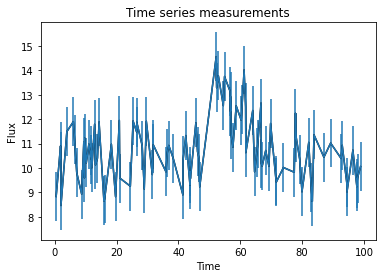

In [4]:
#1
data = np.load('../../homeworks/hw_data/hw5_data_1.npy')

plt.plot(data[:,0],data[:,1],'k')
plt.errorbar(data[:,0],data[0:,1],yerr=data[:,2])
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Time series measurements')
plt.show()

In [5]:
#2
# x is a parameter array
# x= [A,lna,b,t0]

t= data[:,0],
ydata= data[:,1]
sigma= data[:,2]

def burst(x,t):
    y= x[2] + x[0]*np.exp(-np.exp(x[1])*(t-x[3]))

    return y

def Likelihood(x,t,ydata,sigma):
    t= np.asarray(t[0])
    model= np.empty([len(t)])
    for i in range(len(model)):
        if t[i]<x[3]:
            model[i]= x[2]
        else:
            model[i]= burst(x,t[i])
    L= np.prod((1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((ydata-model)**2)/sigma**2))
    #print(L)
    return L

In [14]:
#3
import scipy.stats as stats

def posterior(x,t,ydata,sigma):
    bprior= stats.uniform(0,50).pdf(x[2])
    Aprior=stats.uniform(0,50).pdf(x[0])
    lnaprior= stats.uniform(-5,10).pdf(x[1])
    t0prior= stats.uniform(0,100).pdf(x[3])
    pdf= Likelihood(x,t,ydata,sigma)*bprior*Aprior*lnaprior*t0prior
    return pdf

def logL(x,t,ydata,sigma):
    logL= np.log(posterior(x,t,ydata,sigma))
    #print(logL)
    return logL

#Basically used the same steps as we did for emcee in Lecture 11
ndim = 4  #parameters
nwalkers = 24  # walkers
nstep = 20000  # steps per walker

# initializing near the a priori parameters
starting_guesses= np.empty([24,4])
starting_guesses[:,0]= np.random.random_sample(24)+15
starting_guesses[:,1]= np.random.random_sample(24)
starting_guesses[:,2]= np.random.random_sample(24)+10
starting_guesses[:,3]= 2*np.random.random_sample(24)+45
sampler = emcee.EnsembleSampler(nwalkers,ndim,logL,args=[t,ydata,sigma])
sampler.run_mcmc(starting_guesses, nstep)

<ipython-input-14-0e9257a13d05>:13: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posterior(x,t,ydata,sigma))


State([[ 4.10339546 -2.26694467 10.19339979 50.52530969]
 [ 4.34882437 -2.44205983 10.34562897 48.19697903]
 [ 7.68016386 -2.10606126 10.05782855 47.49007821]
 [ 5.86128061 -2.10276607 10.26034809 50.26919373]
 [ 8.56760823 -1.95921958 10.35527098 47.00315416]
 [ 4.8949536  -2.12458191 10.54856677 47.29549792]
 [ 5.97680295 -1.79063269 10.35756455 50.28129301]
 [ 3.2785102  -2.33525453 10.30892809 51.27169518]
 [ 7.24723437 -2.210361   10.2072319  47.24658944]
 [10.63612447 -1.73298878 10.48330101 47.5155164 ]
 [ 5.03836835 -2.13263839 10.2937183  50.89008201]
 [ 5.95475649 -2.1848427  10.19222768 49.18089116]
 [ 5.41327687 -2.29115987 10.1584333  47.88110711]
 [ 5.25419265 -1.77630459 10.09903562 50.81327889]
 [ 5.01336673 -2.35804109 10.1772498  48.76450524]
 [ 4.03312448 -1.86344558 10.23331369 52.12667186]
 [ 6.36052643 -2.12392782 10.11058479 48.73130619]
 [ 3.89964892 -2.33160199 10.41025116 49.12856592]
 [ 4.92283489 -1.99769206 10.3210777  50.30226411]
 [ 6.82204017 -1.65149195

autocorrelation times = [101.76726738  73.69160849  69.35347021  88.6404551 ]
acceptance fractions = [0.50625 0.50205 0.5155  0.5025  0.5024  0.5065  0.5009  0.507   0.50355
 0.5052  0.49205 0.5059  0.50175 0.51135 0.50815 0.49235 0.50415 0.5147
 0.5056  0.5071  0.19685 0.49315 0.51565 0.51025]


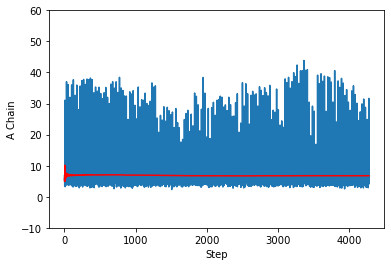

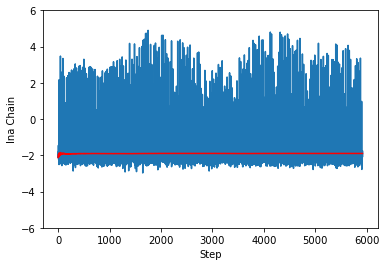

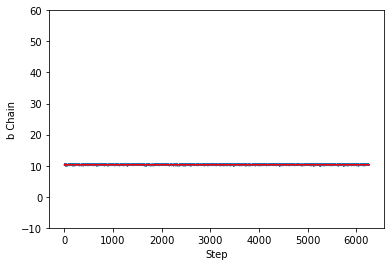

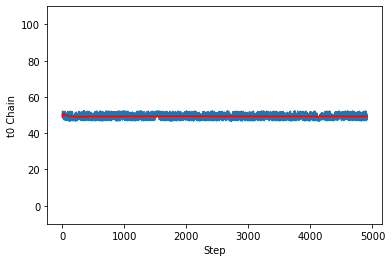

In [46]:
#4
emcee_trace= sampler.get_chain()
emcee_trace_A  = sampler.get_chain()[:,:,0].reshape(-1,1)
emcee_trace_lna  = sampler.get_chain()[:,:,1].reshape(-1,1)
emcee_trace_b  = sampler.get_chain()[:,:,2].reshape(-1,1)
emcee_trace_t0  = sampler.get_chain()[:,:,3].reshape(-1,1)

#I chose 2000 as burn in after looking at the untouched trace plots the first time
autoc = sampler.get_autocorr_time(discard=2000)
print('autocorrelation times = ' +str(autoc))
#A nice check
acc= sampler.acceptance_fraction
print('acceptance fractions = '+str(acc))

#removing burn in 
emcee_trace= emcee_trace[2000:,:,:]
emcee_trace_A= emcee_trace_A[48000:]
emcee_trace_lna= emcee_trace_lna[48000:]
emcee_trace_b= emcee_trace_b[48000:]
emcee_trace_t0= emcee_trace_t0[48000:]
#thinning
emcee_trace_A= emcee_trace_A[::int(autoc[0])]
emcee_trace_lna= emcee_trace_lna[::int(autoc[1])]
emcee_trace_b= emcee_trace_b[::int(autoc[2])]
emcee_trace_t0= emcee_trace_t0[::int(autoc[3])]

plt.plot(np.linspace(1,len(emcee_trace_A),len(emcee_trace_A)),emcee_trace_A)
meanchain = [np.mean(emcee_trace_A[:int(N)]) for N in np.linspace(1,len(emcee_trace_A),len(emcee_trace_A))]
plt.plot(np.linspace(1,len(emcee_trace_A),len(emcee_trace_A)), meanchain, c='red', label='chain mean')
plt.xlabel('Step')
plt.ylabel('A Chain')
plt.ylim(-10,60)
plt.show()

plt.plot(np.linspace(1,len(emcee_trace_lna),len(emcee_trace_lna)),emcee_trace_lna)
meanchain = [np.mean(emcee_trace_lna[:int(N)]) for N in np.linspace(1,len(emcee_trace_lna),len(emcee_trace_lna))]
plt.plot(np.linspace(1,len(emcee_trace_lna),len(emcee_trace_lna)), meanchain, c='red', label='chain mean')
plt.xlabel('Step')
plt.ylabel('lna Chain')
plt.ylim(-6,6)
plt.show()

plt.plot(np.linspace(1,len(emcee_trace_b),len(emcee_trace_b)),emcee_trace_b)
meanchain = [np.mean(emcee_trace_b[:int(N)]) for N in np.linspace(1,len(emcee_trace_b),len(emcee_trace_b))]
plt.plot(np.linspace(1,len(emcee_trace_b),len(emcee_trace_b)), meanchain, c='red', label='chain mean')
plt.xlabel('Step')
plt.ylabel('b Chain')
plt.ylim(-10,60)
plt.show()

plt.plot(np.linspace(1,len(emcee_trace_t0),len(emcee_trace_t0)),emcee_trace_t0)
meanchain = [np.mean(emcee_trace_t0[:int(N)]) for N in np.linspace(1,len(emcee_trace_t0),len(emcee_trace_t0))]
plt.plot(np.linspace(1,len(emcee_trace_t0),len(emcee_trace_t0)), meanchain, c='red', label='chain mean')
plt.xlabel('Step')
plt.ylabel('t0 Chain')
plt.ylim(-10,110)
plt.show()


In [47]:
#5
!pip install corner
import corner


(432000, 4)


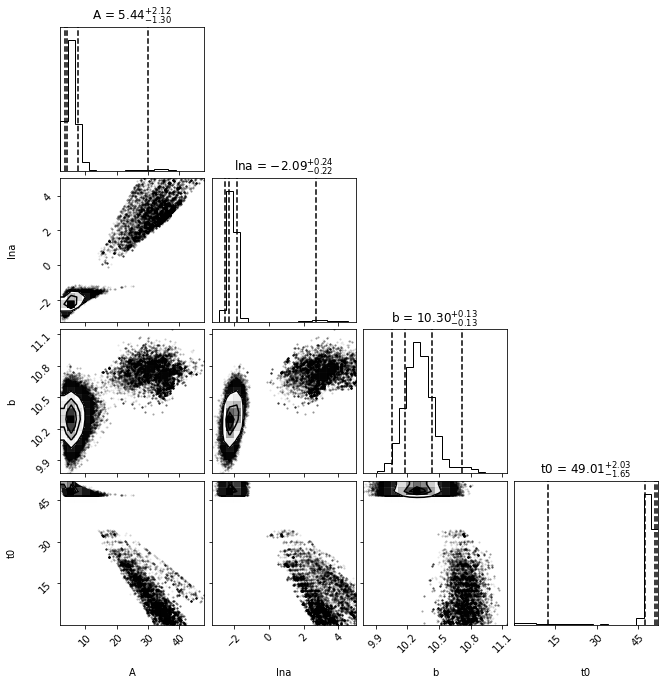

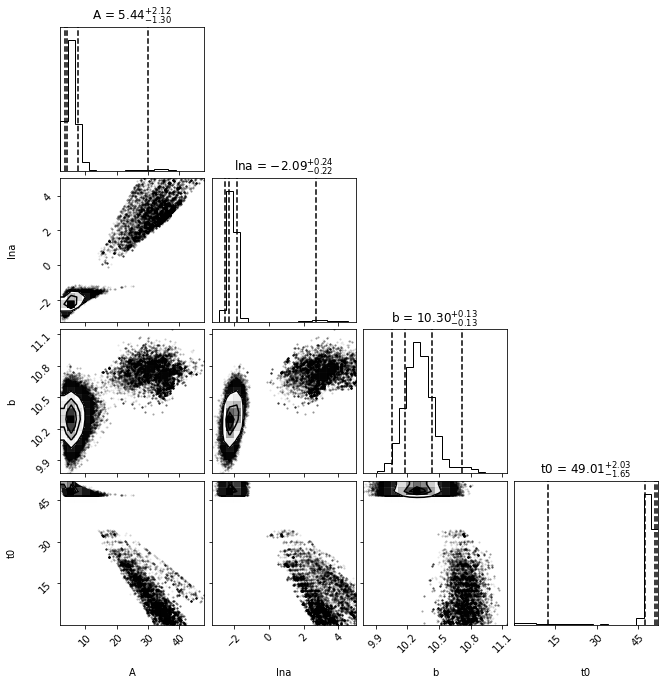

In [49]:
samples= emcee_trace.reshape(-1,4)
print(samples.shape)
corner.corner(samples,labels=['A','lna','b','t0'],quantiles=[0.025,0.16,0.84,0.975],show_titles=True)








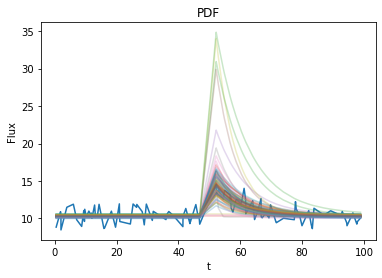

In [71]:
#6
#choosing 100 sets of parameters randomly
params= np.empty([4,100])
Arandom= np.random.choice(np.squeeze(emcee_trace_A),100)
lnarandom= np.random.choice(np.squeeze(emcee_trace_lna),100)
brandom= np.random.choice(np.squeeze(emcee_trace_b),100)
t0random= np.random.choice(np.squeeze(emcee_trace_t0),100)
params[0,:]= Arandom
params[1,:]= lnarandom
params[2,:]= brandom
params[3,:]= t0random

#generating 100 realizations and overplotting the truth
yvals= np.empty([100,len(np.asarray(t[0]))])
plt.plot(data[:,0],data[:,1])
plt.xlabel('t')
plt.ylabel('Flux')
plt.title('PDF')
for i in range(100):
    for j in range(100):
        if data[j,0]<params[3,i]:
            yvals[i,j]=params[2,i]
        else:
            yvals[i,j]= burst(params[:,i],data[j,0])
    plt.plot(data[:,0],yvals[i,:],alpha=0.25)
plt.show()

In [76]:
#7 
!pip install dynesty
import dynesty

     |████████████████████████████████| 87 kB 2.4 MB/s eta 0:00:01


In [80]:
#gauss params = [A lnsigma b t0]
#burst params= [A lna b t0]

ndim = 4
logl_args=[t,ydata,sigma]

def ptfgauss(u):
    x= np.asarray(u)
    x[0]= 50*u[0]
    x[1]= 4*u[1]-2
    x[2]= 50*u[2]
    x[3]= 100*u[3]
    return x

def ptfburst(u):
    x= np.asarray(u)
    x[0]= 50*u[0]
    x[1]= 10*u[1]-5
    x[2]= 50*u[2]
    x[3]= 100*u[3]
    return x

def gauss(x,t):
    y= x[2] + x[0]*np.exp((-(t-x[3])**2)/2*((np.exp(x[1]))**2))
    return y

def Likelihoodgauss(x,t,ydata,sigma):
    t= np.asarray(t[0])
    model= gauss(x,t)
    L= np.prod((1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((ydata-model)**2)/sigma**2))
    return L

def posteriorgauss(x,t,ydata,sigma):
    bprior= stats.uniform(0,50).pdf(x[2])
    Aprior=stats.uniform(0,50).pdf(x[0])
    lnsigmaprior= stats.uniform(-2,4).pdf(x[1])
    t0prior= stats.uniform(0,100).pdf(x[3])
    pdf= Likelihoodgauss(x,t,ydata,sigma)*bprior*Aprior*lnsigmaprior*t0prior
    return pdf

def logLgauss(x,t,ydata,sigma):
    logL= np.log(posteriorgauss(x,t,ydata,sigma))
    return logL

In [81]:
samplerburst = dynesty.NestedSampler(logL,ptfburst,ndim,logl_args=logl_args)
samplerburst.run_nested()
sresultsburst = samplerburst.results

samplergauss = dynesty.NestedSampler(logLgauss, ptfgauss, ndim, logl_args=logl_args)
samplergauss.run_nested()
sresultsgauss = samplergauss.results

<ipython-input-14-0e9257a13d05>:13: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posterior(x,t,ydata,sigma))
460it [00:17, 18.73it/s, bound: 0 | nc: 57 | ncall: 5911 | eff(%):  7.782 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.509]<ipython-input-14-0e9257a13d05>:13: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posterior(x,t,ydata,sigma))
666it [00:20, 89.72it/s, bound: 1 | nc: 2 | ncall: 6672 | eff(%):  9.982 | loglstar:   -inf < -490.202 <    inf | logz: -497.651 +/-    nan | dlogz: 312.453 >  0.509] <ipython-input-14-0e9257a13d05>:13: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posterior(x,t,ydata,sigma))
860it [00:22, 62.75it/s, bound: 2 | nc: 8 | ncall: 7425 | eff(%): 11.582 | loglstar:   -inf < -356.291 <    inf | logz: -363.928 +/-    nan | dlogz: 178.131 >  0.509] <ipython-input-14-0e9257a13d05>:13: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posterior(x,t,yd

4261it [01:34, 42.01it/s, bound: 27 | nc: 8 | ncall: 26341 | eff(%): 16.176 | loglstar:   -inf < -175.548 <    inf | logz: -186.188 +/-    nan | dlogz: 21.993 >  0.509] <ipython-input-14-0e9257a13d05>:13: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posterior(x,t,ydata,sigma))
4384it [01:37, 43.68it/s, bound: 28 | nc: 17 | ncall: 27104 | eff(%): 16.175 | loglstar:   -inf < -173.879 <    inf | logz: -184.449 +/-    nan | dlogz: 20.073 >  0.509]<ipython-input-14-0e9257a13d05>:13: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posterior(x,t,ydata,sigma))
4514it [01:39, 51.28it/s, bound: 30 | nc: 8 | ncall: 27868 | eff(%): 16.198 | loglstar:   -inf < -171.400 <    inf | logz: -182.486 +/-    nan | dlogz: 17.854 >  0.509] <ipython-input-14-0e9257a13d05>:13: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posterior(x,t,ydata,sigma))
4623it [01:42, 27.61it/s, bound: 30 | nc: 53 | ncall: 28651 | eff(%): 16.136 | loglstar:   -inf < -169.816

3156it [01:15, 18.47it/s, bound: 21 | nc: 12 | ncall: 23399 | eff(%): 13.488 | loglstar:   -inf < -192.762 <    inf | logz: -198.602 +/-    nan | dlogz: 32.372 >  0.509]<ipython-input-80-8e3b0d516616>:42: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posteriorgauss(x,t,ydata,sigma))
3188it [01:18,  9.02it/s, bound: 22 | nc: 70 | ncall: 24178 | eff(%): 13.186 | loglstar:   -inf < -192.564 <    inf | logz: -198.560 +/-    nan | dlogz: 32.267 >  0.509]<ipython-input-80-8e3b0d516616>:42: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posteriorgauss(x,t,ydata,sigma))
3247it [01:20, 20.48it/s, bound: 24 | nc: 8 | ncall: 24975 | eff(%): 13.001 | loglstar:   -inf < -191.870 <    inf | logz: -198.460 +/-    nan | dlogz: 32.050 >  0.509] <ipython-input-80-8e3b0d516616>:42: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posteriorgauss(x,t,ydata,sigma))
3350it [01:23, 30.79it/s, bound: 24 | nc: 12 | ncall: 25673 | eff(%): 13.049 | loglstar:   

In [92]:
from dynesty import plotting as dyplot
sresultsburst.summary()
sresultsgauss.summary()

print('Bayes Factor burst/gauss ='+str(10**-168.527/10**-171.852))
#The burst model is much preferred.

Summary
nlive: 500
niter: 6962
ncall: 42873
eff(%): 17.405
logz: -168.527 +/- 1704209464640620497791827892091989604562064640110770940599316631078066708730261823659543998308018300073939562145358468492867113757531252457472.000
Summary
nlive: 500
niter: 7212
ncall: 52931
eff(%): 14.570
logz: -171.852 +/- 1616755055484164112104885847013118145541357645163114957926881453581171815629744616669589548563697870738105750604301793065829379580816877682688.000
Bayes Factor burst/gauss =2113.4890398367293


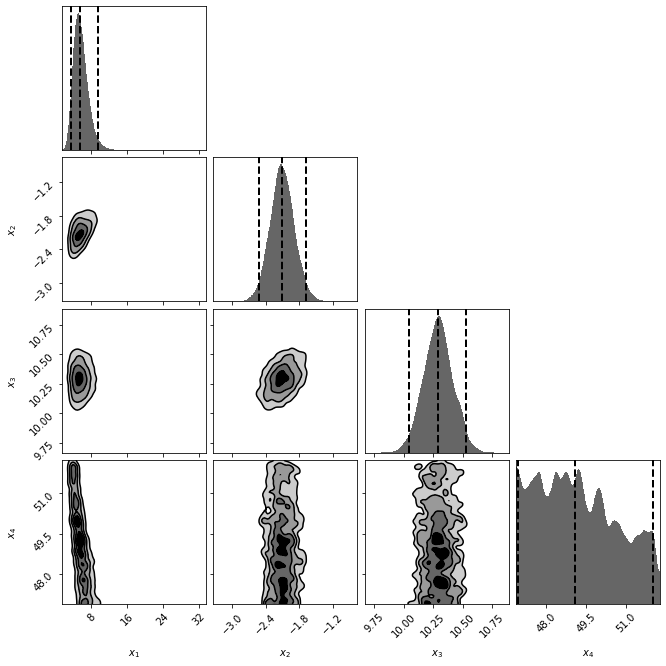

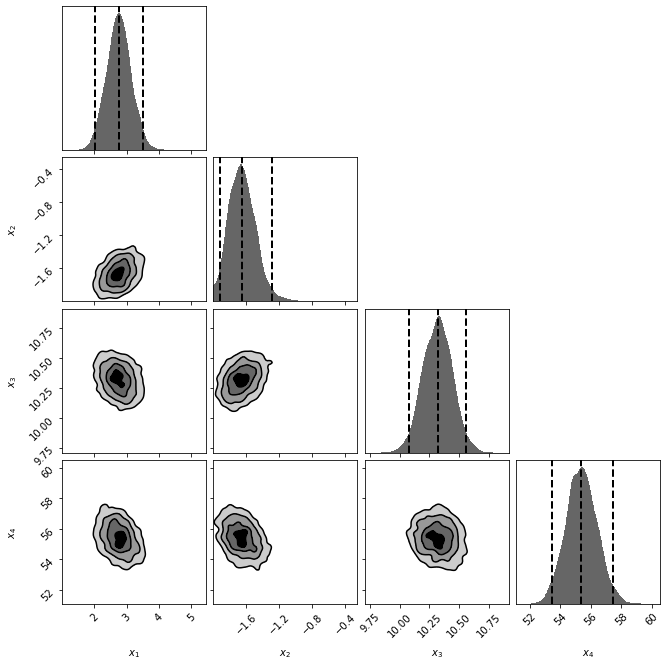

In [91]:
cfig, caxes = dyplot.cornerplot(sresultsburst)
dfig, daxes = dyplot.cornerplot(sresultsgauss)